In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, ArrayType, StringType

In [0]:
base_df = spark.sql("select * from batch.dpechi.adas_endpoint_payload")
base_df.display()

client_request_id,databricks_request_id,date,timestamp_ms,status_code,execution_time_ms,request,response,sampling_fraction,request_metadata
null,c3b0362e-1acb-4547-b590-8281d2a2368c,2024-12-02,1733180328417,200,4369,"{ ""inputs"": [""Program to do multi-hop reasoning""] }","{""predictions"": {""new_module"": ""```python\nclass MultiHopReasoning(dspy.Module):\n \""\""\""Module for multi-hop reasoning.\""\""\""\n\n def __init__(self):\n super().__init__()\n\n # Define the signatures for multi-hop reasoning\n self.hop = dspy.ChainOfThought(\""context, question -> next_question, next_context\"")\n self.answer = dspy.ChainOfThought(\""context, question -> answer\"")\n\n def forward(self, context: str, question: str) -> dict:\n \""\""\""Generate answer for a question with multi-hop reasoning.\""\""\""\n current_context = context\n current_question = question\n\n for _ in range(3): # Max 3 hops\n hop_output = self.hop(context=current_context, question=current_question).output\n next_question = hop_output['next_question']\n next_context = hop_output['next_context']\n\n if not next_question:\n break\n\n current_context = next_context\n current_question = next_question\n\n answer = self.answer(context=current_context, question=current_question).answer\n\n return {\n \""context\"": current_context,\n \""question\"": current_question,\n \""answer\"": answer\n }\n```""}}",1.0,"Map(model_name -> ADAS_agent, endpoint_name -> ADAS_endpoint, model_version -> 11)"
null,548abb9e-8c76-4ade-8523-860dc9c88b27,2024-12-02,1733180350372,200,2044,"{ ""inputs"": [""Program to classify sentiment""] }","{""predictions"": {""new_module"": ""class SentimentClassifier(dspy.Module):\ndef **init**(self):\nsuper().**init**()\nself.classify = dspy.Classify(\n\""input -> sentiment\"",\nchoices=[\n{\""sentiment\"": \""positive\""},\n{\""sentiment\"": \""negative\""},\n{\""sentiment\"": \""neutral\""},\n]\n)\n\ndef forward(self, input):\nglobal last\\_program\nlast\\_program = self\nreturn self.classify(input=input)""}}",1.0,"Map(model_name -> ADAS_agent, endpoint_name -> ADAS_endpoint, model_version -> 11)"
null,76ea7e5e-cd0b-4339-bc90-70fab34fb375,2024-12-02,1733180535363,200,5079,"{ ""inputs"": [""Program to extract character biographies from book""] }","{""predictions"": {""new_module"": ""```python\nclass ExtractCharacterBiographies(dspy.Module):\n \""\""\""Extract character biographies from a given book.\""\""\""\n \n def __init__(self, engine: Union[dspy.dsp.LM, dspy.dsp.HFModel]):\n super().__init__()\n self.find_character_mentions = dspy.ChainOfThought(FindCharacterMentions)\n self.extract_biography = dspy.ChainOfThought(ExtractBiography)\n self.engine = engine\n\n def forward(self, text: str, character=None):\n with dspy.settings.context(lm=self.engine):\n if not character:\n character_mentions = self.find_character_mentions(text=text).character_mentions\n if len(character_mentions) == 0:\n return dspy.Prediction(biographies=[], raw_biographies_output='No character mentions found.')\n else:\n character = character_mentions[0]\n\n biography = self.extract_biography(text=text, character=character).biography\n\n return dspy.Prediction(biographies=[biography], raw_biographies_output=biography)\n```""}}",1.0,"Map(model_name -> ADAS_agent, endpoint_name -> ADAS_endpoint, model_version -> 11)"
null,74566927-24e3-45f5-a299-c58686c20db1,2024-12-02,1733180420704,200,4006,"{ ""inputs"": [""Program to synthesize research paper""] }","{""predictions"": {""new_module"": ""class SynthesizeResearchPaper(dspy.Module):\n \""\""\""\n SynthesizeResearchPaper is a module that takes in a research paper and returns a synthesized version.\n \""\""\""\n\n def __init__(self, index, query_processor):\n self.generate_queries = SynthesizeQueries(\n self.index = index\n self.query_processor = query_processor\n \n def forward(self, text: str) -> dspy.Prediction:\n queries = []\n for i in range(0, len(text), 2000):\n query = self.generate_queries(document=text[i:i+2000]).query\n process

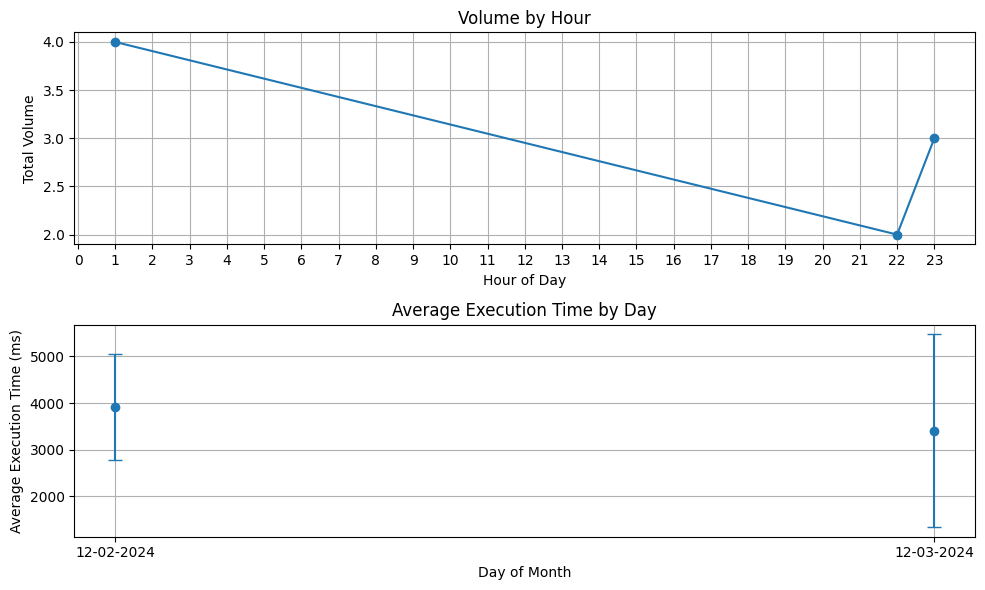

In [0]:
# Convert timestamp_ms from BIGINT to TIMESTAMP
base_df = base_df.withColumn("timestamp", F.from_unixtime(F.col("timestamp_ms") / 1000))

# Extract hour from timestamp and aggregate volume by hour
hourly_volume_df = base_df.withColumn("hour", F.hour("timestamp")) \
                          .groupBy("hour") \
                          .agg(F.count("timestamp_ms").alias("total_volume")) \
                          .orderBy("hour")

# Extract day from timestamp and calculate average execution time and stddev by day
daily_exec_time_stats_df = base_df.withColumn("day", F.date_format("timestamp", "MM-dd-yyyy")) \
                                  .groupBy("day") \
                                  .agg(F.avg("execution_time_ms").alias("avg_execution_time"),
                                       F.stddev("execution_time_ms").alias("stddev_execution_time")) \
                                  .orderBy("day")

# Convert to Pandas DataFrame for plotting
hourly_volume_pd = hourly_volume_df.toPandas()
daily_exec_time_stats_pd = daily_exec_time_stats_df.toPandas()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(hourly_volume_pd['hour'], hourly_volume_pd['total_volume'], marker='o')
plt.title('Volume by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Total Volume')
plt.grid(True)
plt.xticks(range(0, 24))

plt.subplot(2, 1, 2)
plt.errorbar(daily_exec_time_stats_pd['day'], daily_exec_time_stats_pd['avg_execution_time'], 
             yerr=daily_exec_time_stats_pd['stddev_execution_time'], fmt='o', capsize=5)
plt.title('Average Execution Time by Day')
plt.xlabel('Day of Month')
plt.ylabel('Average Execution Time (ms)')
plt.grid(True)

plt.tight_layout()
plt.show()

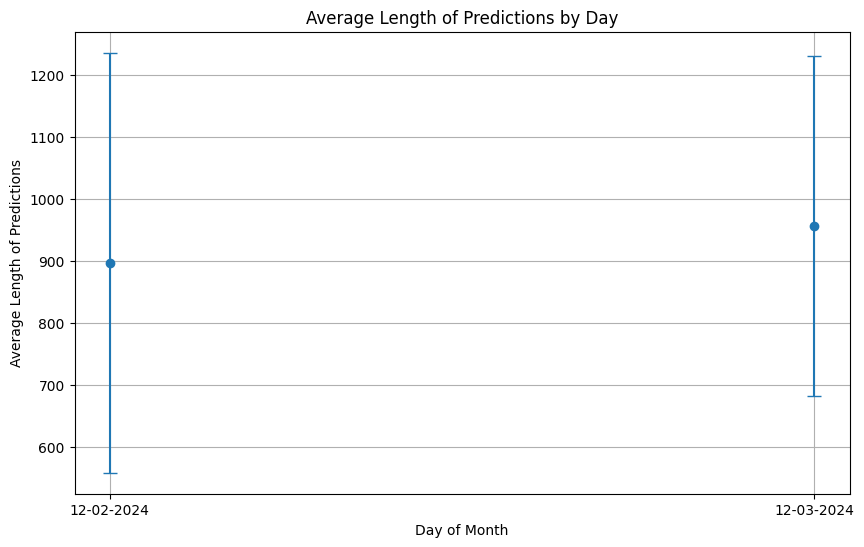

In [0]:
# Extract predictions from the response column
json_schema = StructType([
    StructField("predictions", StructType([
        StructField("new_module", StringType(), True)
    ]))
])

# Parse the JSON string in the 'predictions' column
base_df = base_df.withColumn("parsed_predictions", F.from_json(F.col("response"), json_schema))

# Calculate the length of the 'new_module' field
base_df = base_df.withColumn("prediction_length", F.length(F.col("parsed_predictions.predictions.new_module")))

# Extract day from timestamp and calculate average length of predictions and stddev by day
daily_pred_length_stats_df = base_df.withColumn("day", F.date_format("timestamp", "MM-dd-yyyy")) \
                                    .groupBy("day") \
                                    .agg(F.avg("prediction_length").alias("avg_prediction_length"),
                                         F.stddev("prediction_length").alias("stddev_prediction_length")) \
                                    .orderBy("day")

# Convert to Pandas DataFrame for plotting
daily_pred_length_stats_pd = daily_pred_length_stats_df.toPandas()

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(daily_pred_length_stats_pd['day'], daily_pred_length_stats_pd['avg_prediction_length'], 
             yerr=daily_pred_length_stats_pd['stddev_prediction_length'], fmt='o', capsize=5)
plt.title('Average Length of Predictions by Day')
plt.xlabel('Day of Month')
plt.ylabel('Average Length of Predictions')
plt.grid(True)
plt.show()